In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from math import nan

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import keras.losses as kl
from tensorflow.keras.callbacks import EarlyStopping

from core.classes import FeatureEngineer, DataImputation

pd.set_option('display.max_columns', None)

In [26]:
path = '../data/processed/combined_data.csv'
df = pd.read_csv(path, index_col='date', skipfooter=1)


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\3028427092.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, index_col='date', skipfooter=1)


In [41]:
demand = (df.iloc[:, 44])
price = df.iloc[:, 121]
demand_change = demand.pct_change()
price_change = price.pct_change()
elasticity = demand_change / price_change
df['elasticity'] = elasticity

demand_coffee = (df.iloc[:, 62])
price_coffee = df.iloc[:, 143]
demand_change_coffee = demand_coffee.pct_change()
price_change_coffee = price_coffee.pct_change()
elasticity_coffee = demand_change_coffee / price_change_coffee
df['elasticity_coffee'] = elasticity_coffee

In [42]:
df

,Betriebe_WZ08-10,Betriebe_ep_WZ08-10,Beschäftigte_WZ08-10,Beschäftigte_ep_WZ08-10,Geleistete Arbeitsstunden_WZ08-10,Geleistete Arbeitsstunden_ep_WZ08-10,Bruttolohn- und -gehaltssumme_WZ08-10,Bruttolohn- und -gehaltssumme_ep_WZ08-10,Umsatz_WZ08-10,Umsatz_ep_WZ08-10,Inlandsumsatz_WZ08-10,Inlandsumsatz_ep_WZ08-10,Auslandsumsatz_WZ08-10,Auslandsumsatz_ep_WZ08-10,Auslandsumsatz mit der Eurozone_WZ08-10,Auslandsumsatz mit der Eurozone_ep_WZ08-10,Auslandsumsatz mit dem sonstigen Ausland_WZ08-10,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-10,Betriebe_WZ08-108,Betriebe_ep_WZ08-108,Beschäftigte_WZ08-108,Beschäftigte_ep_WZ08-108,Geleistete Arbeitsstunden_WZ08-108,Geleistete Arbeitsstunden_ep_WZ08-108,Bruttolohn- und -gehaltssumme_WZ08-108,Bruttolohn- und -gehaltssumme_ep_WZ08-108,Umsatz_WZ08-108,Umsatz_ep_WZ08-108,Inlandsumsatz_WZ08-108,Inlandsumsatz_ep_WZ08-108,Auslandsumsatz_WZ08-108,Auslandsumsatz_ep_WZ08-108,Auslandsumsatz mit der Eurozone_WZ08-108,Auslandsumsatz mit der Eurozone_ep_WZ08-108,Auslandsumsatz mit dem sonstigen Ausland_WZ08-108,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-108,Betriebe_WZ08-1082,Betriebe_ep_WZ08-1082,Beschäftigte_WZ08-1082,Beschäftigte_ep_WZ08-1082,Geleistete Arbeitsstunden_WZ08-1082,Geleistete Arbeitsstunden_ep_WZ08-1082,Bruttolohn- und -gehaltssumme_WZ08-1082,Bruttolohn- und -gehaltssumme_ep_WZ08-1082,Umsatz_WZ08-1082,Umsatz_ep_WZ08-1082,Inlandsumsatz_WZ08-1082,Inlandsumsatz_ep_WZ08-1082,Auslandsumsatz_WZ08-1082,Auslandsumsatz_ep_WZ08-1082,Auslandsumsatz mit der Eurozone_WZ08-1082,Auslandsumsatz mit der Eurozone_ep_WZ08-1082,Auslandsumsatz mit dem sonstigen Ausland_WZ08-1082,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-1082,Betriebe_WZ08-1083,Betriebe_ep_WZ08-1083,Beschäftigte_WZ08-1083,Beschäftigte_ep_WZ08-1083,Geleistete Arbeitsstunden_WZ08-1083,Geleistete Arbeitsstunden_ep_WZ08-1083,Bruttolohn- und -gehaltssumme_WZ08-1083,Bruttolohn- und -gehaltssumme_ep_WZ08-1083,Umsatz_WZ08-1083,Umsatz_ep_WZ08-1083,Inlandsumsatz_WZ08-1083,Inlandsumsatz_ep_WZ08-1083,Auslandsumsatz_WZ08-1083,Auslandsumsatz_ep_WZ08-1083,Auslandsumsatz mit der Eurozone_WZ08-1083,Auslandsumsatz mit der Eurozone_ep_WZ08-1083,Auslandsumsatz mit dem sonstigen Ausland_WZ08-1083,Auslandsumsatz mit dem sonstigen Ausland_ep_WZ08-1083,ErzPr_Nahrungsmittel und Futtermittel,ErzPr_Sonstige Nahrungsmittel (ohne Getränke),ErzPr_Süßwaren (ohne Dauerbackwaren),ErzPr_Schokoladen und andere Süßwaren,"ErzPr_Schokolade u.a. kakaoh. Lebensm.zub.,in Verp.>2kg","ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg",ErzPr_Süßwaren oh. Kakaogeh. (einschl.weißer Schokolade),"ErzPr_Kaffee und Tee, Kaffee-Ersatz","ErzPr_Kaffee und Tee, Kaffee-Ersatz.1","ErzPr_Kaffee, entkoffeiniert oder geröstet","ErzPr_Kaffeemittel m. -geh.,Auszüge,Essenz.,Konzentrate","ErzPr_Grüner Tee (n. ferment.), schwarzer Tee (ferment.)",ErzPr_Kräutertees,EinfPr_Nahrungsmittel und Futtermittel,EinfPr_Sonstige Nahrungsmittel (ohne Getränke),EinfPr_Süßwaren (ohne Dauerbackwaren),"EinfPr_Kaffee und Tee, Kaffee-Ersatz",VPI_Nahrungsmittel und alkoholfreie Getränke,VPI_Nahrungsmittel,"VPI_Zucker, Marmelade, Honig und andere Süßwaren",VPI_Schokoladen,VPI_Süßwaren,VPI_Alkoholfreie Getränke,"VPI_Kaffee, Tee und Kakao",VPI_Kaffee und Ähnliches,VPI_Tee und teeähnliche Erzeugnisse,VPI_Kakaopulver oder Ähnliches,"Wert der zum Absatz bestimmten Produktion_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Wert der zum Absatz bestimmten Produktion_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_t_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_t_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_kg_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Gewicht der zum Absatz bestimmten Produktion_kg_ep_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Menge der zum Absatz bestimmten Produktion_stueck_Leb-, Honigkuchen, Kekse, Kleingebäck, Waffeln","Menge de

In [43]:
class Model(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)

        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        self.model_middle.fit( feat_middle.loc[:,['target_pred_by_1', 'Ferrero']],target_middle)

        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])

        self.model_end.fit(feat_end.loc[:,['target_pred_by_2', 'LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()

        #feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        #target_start = y
        #model_start.fit(feat_start.loc[:, self.columns + ['Mondelez.1']], target_start)
        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])
        result.loc[: ,'pred_m']= self.model_start.predict(X.loc[:, self.columns + ['Mondelez']])
       
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[:, ['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_end.loc[:,  ['target_pred_by_2', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.weight_mond_fer + result.loc[~mask_f & mask_l, 'pred_mf'] * self.weight_fer_fer 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.weight_mond + result.loc[~mask_l,'pred_mf'] * self.weight_fer + result.loc[~mask_l,'pred_mfl'] * self.weight_lindt
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [79]:
def preprocessing(df, dict_lag,number_train, target_name):
    shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
    columns = [x for x in list(dict_lag) if x not in shares]
    df_selected_col = df.loc[:, shares + columns + [target_name]]
    df_selected_col = df_selected_col.dropna(subset = target_name)
    df_train = df_selected_col.iloc[:number_train, :]
    df_test = df_selected_col.iloc[number_train: , :]
    target_train = df_train[target_name]
    target_test = df_test[target_name]
    features_train = df_train.loc[:, shares + columns]
    features_test = df_test.loc[:, shares + columns]
    pipeline = Pipeline([('DaIm', DataImputation(shares)), 
                     ('FE', FeatureEngineer(dict_lag)),
                     ('sca', StandardScaler())])
    
    features_train_transf = pipeline.fit_transform(features_train)
    features_test_transf = pipeline.transform(features_test)
    # make the features into a dataframe again
    features_train_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_train_transf)
    features_train_transf.index=features_train.index
    features_test_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_test_transf)
    features_test_transf.index=features_test.index
    columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    return features_train_transf, features_test_transf, target_train, target_test, columns

In [80]:
def train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name):

    features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

    # Model
    #columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    mod = Model( columns,
             model_start, model_middle, 
             model_end)
    mod.fit(features_train_transf , target_train)

    #Predict Train data
    results = mod.predict(features_train_transf, target_train)
    print('MSE on Train set: ', mean_squared_error(results['final'], target_train))
    results['target']=target_train
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results.index,results.pred_m.values, label = 'm', color = 'blue');
    ax.plot(results.index,results.pred_mf.values, label = 'mf', color = 'lightblue');
    ax.plot(results.index,results.pred_mfl.values, label = 'mfl', color = 'green');
    ax.plot(results.index,results.final.values, label = 'final', color = 'purple');
    ax.plot(results.index, target_train,  label = 'target', color = 'orange');
    plt.xticks(rotation=90)
    ax.legend()
    # Predict testdata 
    results_test = mod.predict(features_test_transf, target_test)
    results_test['target']=target_test
    print('MSE on Test set: ', mean_squared_error(results_test['final'], target_test))
    fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax_test.plot(results_test.index,results_test.pred_m.values, label = 'm', color = 'blue');
    ax_test.plot(results_test.index,results_test.pred_mf.values, label = 'mf', color = 'lightblue');
    ax_test.plot(results_test.index,results_test.pred_mfl.values, label = 'mfl', color = 'green');
    ax_test.plot(results_test.index,results_test.final.values, label = 'final', color = 'purple');
    ax_test.plot(results_test.index,target_test, label = 'target', color = 'orange');
    plt.xticks(rotation=90)
    ax_test.legend()
    return results, results_test
    

In [60]:
columns = [#'Beschäftigte_WZ08-1082',
 #'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity'
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in [#'Beschäftigte_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in ['Geleistete Arbeitsstunden_WZ08-1082',
 'Bruttolohn- und -gehaltssumme_WZ08-1082','ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})


<Axes: >

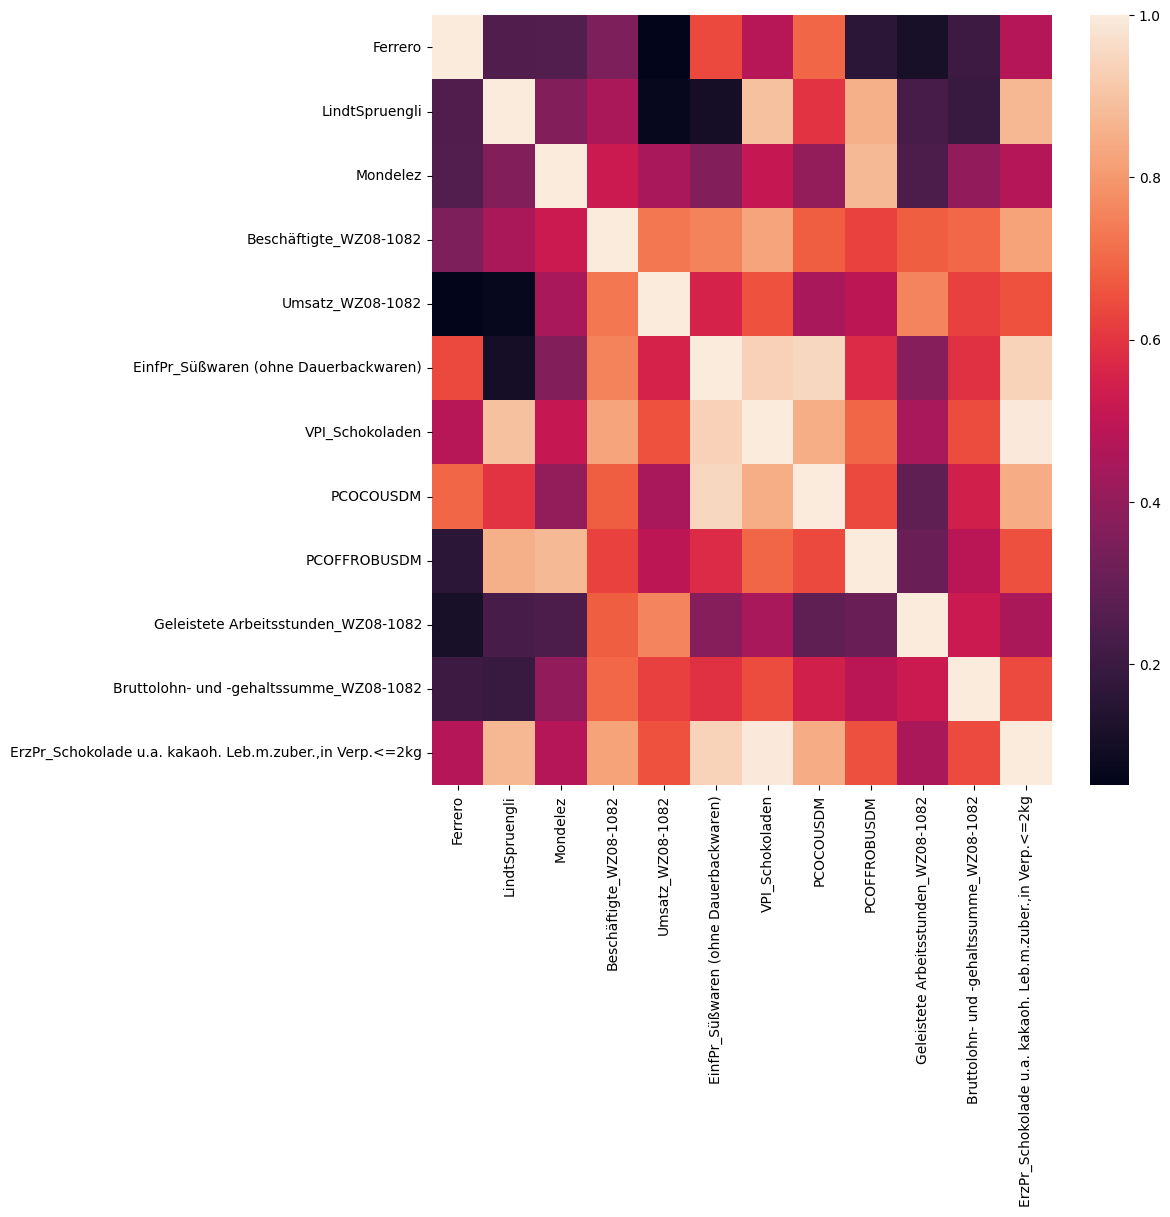

In [51]:
corr = df.loc[:,list(dict_lag)].corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

## Linear Regression

MSE on Train set:  51.601203886106504
MSE on Test set:  225.16518424943868


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.32420587  0.11018998 -2.06756819 -0.44286412 -1.91647781  0.79930072
  0.87057371  2.4813105   2.91572299  0.72974529 -2.58854831  3.18073362
  1.86084226 -0.88387522 -3.29305559 -3.3848287  -2.31337141 -0.20248022
  0.74996959  1.38836302  1.56350491 -1.77090913 -3.91346292 -1.38845626
 -3.66129019 -2.85316993]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -1.57954388  -2.14126174  -8.6940666   -6.24462731  -7.14791609
  -7.93287614  -9.81227419 -13.51698428]' has dtype incompatible with int

(              pred_m   pred_mf  pred_mfl     final     target
 index                                                        
 2019-02-28  0.324206       NaN       NaN  0.324206   2.208051
 2019-03-31  0.110190       NaN       NaN  0.110190  -0.367747
 2019-04-30 -2.067568       NaN       NaN -2.067568  -1.450762
 2019-05-31 -0.442864       NaN       NaN -0.442864  -0.543008
 2019-06-30 -1.916478       NaN       NaN -1.916478  -1.837945
 ...              ...       ...       ...       ...        ...
 2024-11-30  3.673949  2.599822  7.135566  3.404264   0.306333
 2024-12-31  1.224482  0.104979  6.546173  1.010878  20.434410
 2025-01-31 -1.985107 -3.335890  6.758970 -2.151384   1.778236
 2025-02-28  1.896755  0.099323  3.790857  1.291982   1.563292
 2025-03-31  0.857092 -0.650494 -0.504683  0.233682  -0.355388
 
 [74 rows x 5 columns],
                pred_m    pred_mf  pred_mfl      final     target
 index                                                           
 2025-04-30  -1.346038 

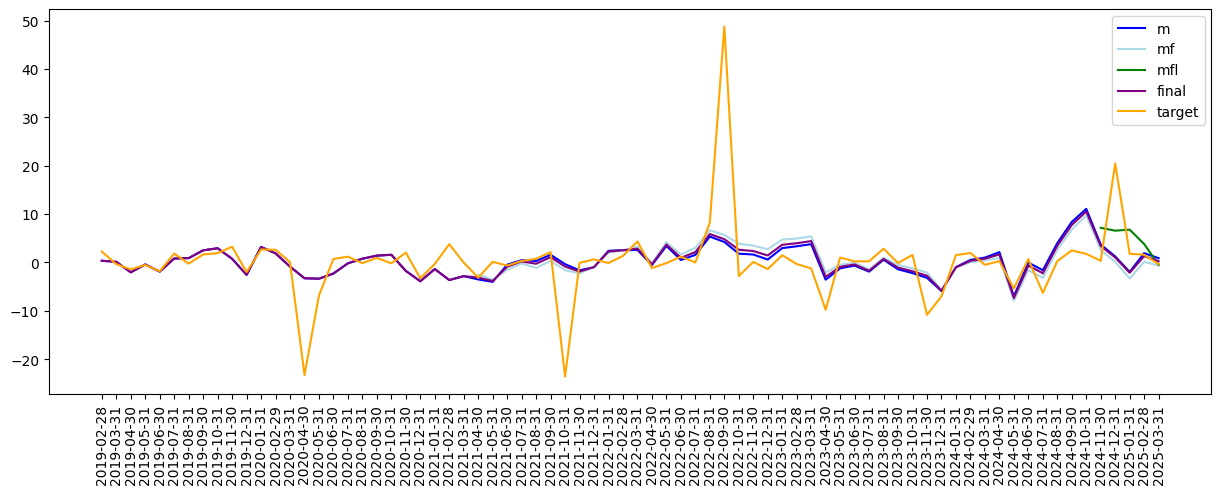

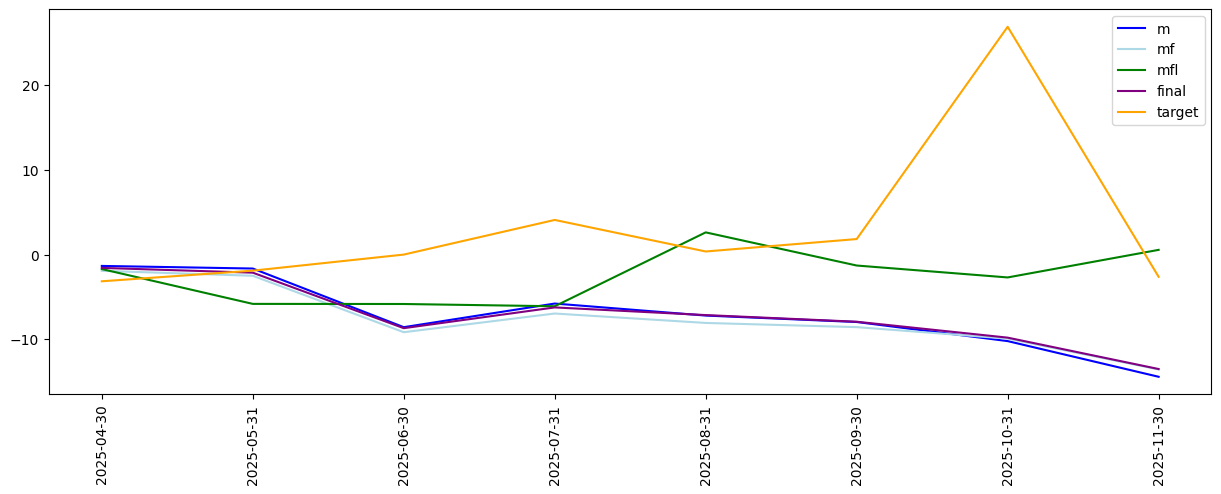

In [81]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)

## LinearSVR

MSE on Train set:  57.690410970727584
MSE on Test set:  93.36426806097477


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.12057448 -0.36033933 -1.37860981 -0.41672193 -1.29092806  1.10303841
  1.27472225  1.6931371   1.90119145  0.17184609 -1.77028758  1.69444049
  0.88604356  0.11720366 -2.21414605 -2.92584743 -1.74382952  0.09206065
 -0.16394486  1.18591881  1.2282894  -0.68100745 -2.13369993 -0.41661393
 -1.07075409 -0.08610061]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.66779049 -0.75859363 -1.33010036  0.79602048 -0.56508377  0.29611547
 -0.01636503 -2.83524037]' has dtype incompatible with int64, plea

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-02-28,-0.120574,NaN,NaN,-0.120574,2.208051
2019-03-31,-0.360339,NaN,NaN,-0.360339,-0.367747
2019-04-30,-1.378610,NaN,NaN,-1.378610,-1.450762
2019-05-31,-0.416722,NaN,NaN,-0.416722,-0.543008
2019-06-30,-1.290928,NaN,NaN,-1.290928,-1.837945
...,...,...,...,...,...
2024-11-30,-0.515478,-0.287206,2.053027,-0.328080,0.306333
2024-12-31,-2.399987,-2.033171,0.977069,-2.128393,20.434410
2025-01-31,1.778236,1.961019,1.778236,1.847319,1.778236


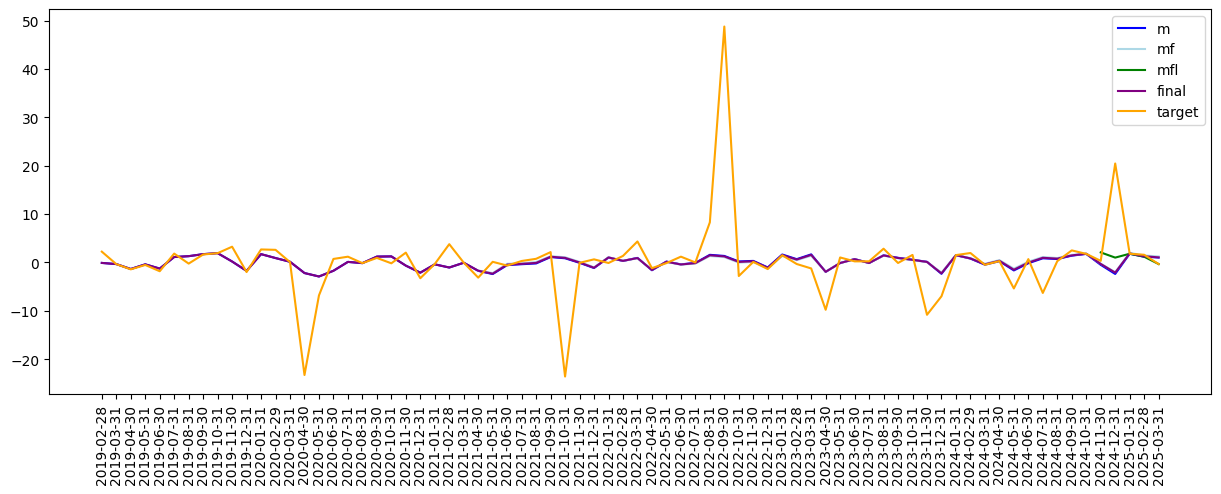

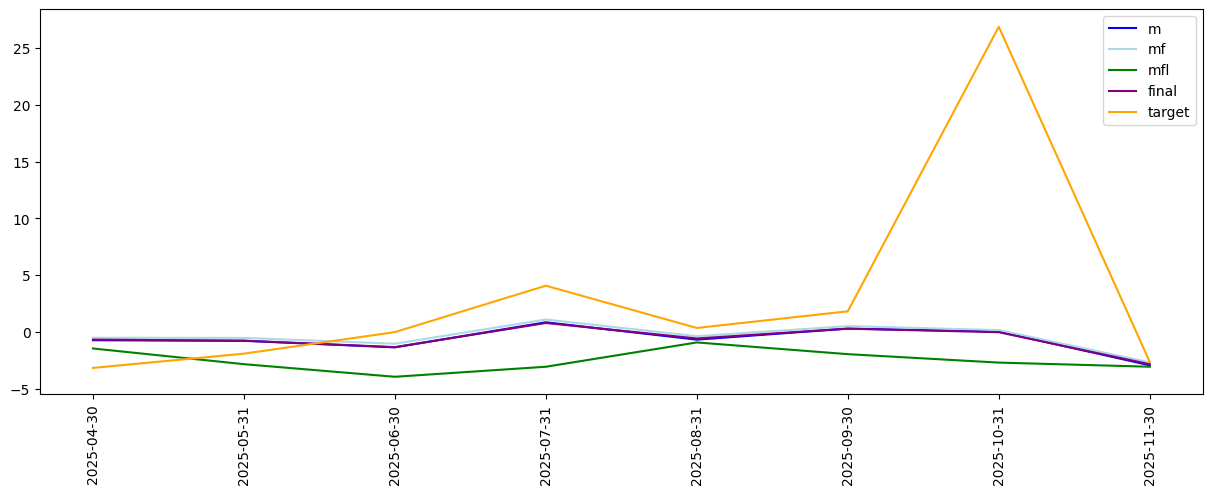

In [71]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results

MSE on Train set:  56.585450027660535
MSE on Test set:  91.57247156224618


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.01939008 -0.27474119 -1.35097745 -0.01267922 -1.31720887  1.13862993
  1.24249559  1.52066134  1.70838786  1.46165272 -1.55315977  1.39313534
  0.66836018  0.19410679 -1.89809263 -1.96856659 -1.60566529  0.34252643
 -0.19862283  1.10900907  1.24069695  1.17559594 -1.65308204 -0.30859884
 -0.90120453  0.37656378]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.08730567 1.07237447 0.83030069 0.84623532 0.79111523 0.70609617
 0.73092555 0.38645889]' has dtype incompatible with int64, please expli

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-02-28,-0.019390,NaN,NaN,-0.019390,2.208051
2019-03-31,-0.274741,NaN,NaN,-0.274741,-0.367747
2019-04-30,-1.350977,NaN,NaN,-1.350977,-1.450762
2019-05-31,-0.012679,NaN,NaN,-0.012679,-0.543008
2019-06-30,-1.317209,NaN,NaN,-1.317209,-1.837945
...,...,...,...,...,...
2024-11-30,0.341503,0.406392,0.414740,0.368911,0.306333
2024-12-31,0.699308,0.886007,1.323854,0.794460,20.434410
2025-01-31,1.462787,1.361803,1.678367,1.433107,1.778236


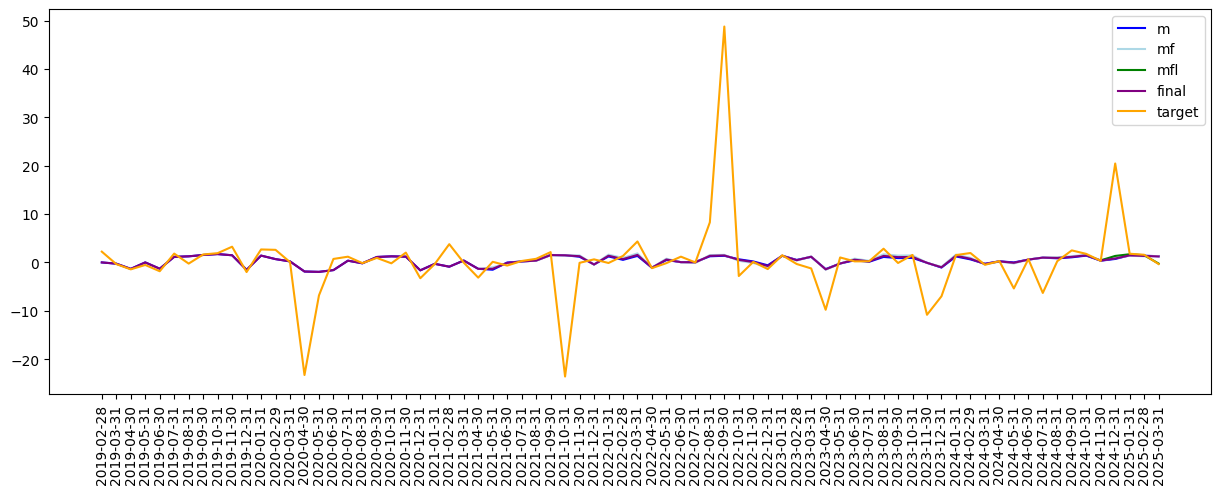

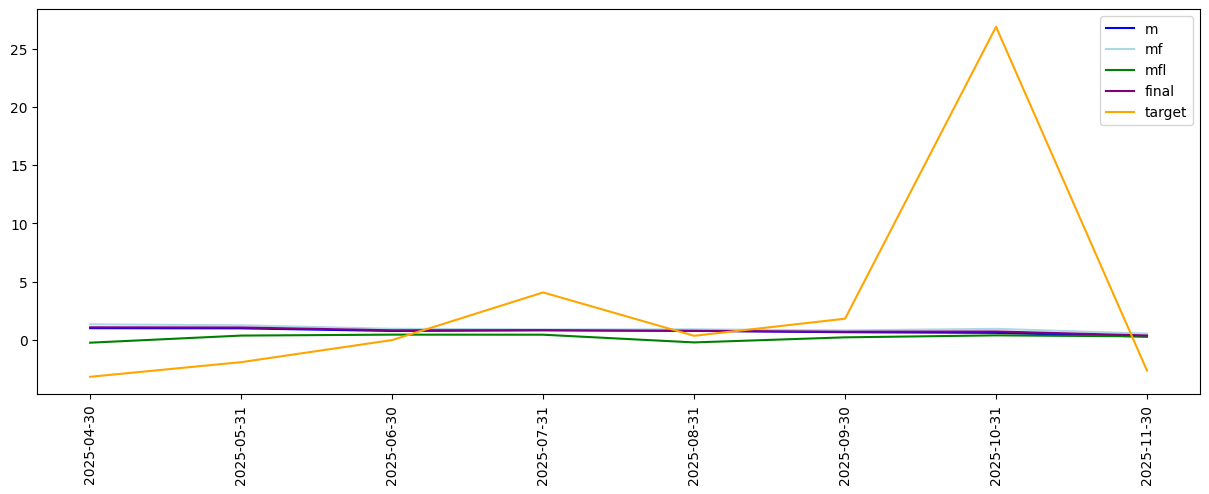

In [72]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results

## Random Forest

MSE on Train set:  14.032132235875135
MSE on Test set:  140.1619641933068


C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  1.1224724    0.09215334  -0.95360413   0.92042552  -1.02201516
   1.27494686   1.27494686   4.40250435   1.3777492    1.8874951
  -1.5592137    1.3777492    0.70565831   0.98779388 -23.29519975
 -13.41970442  -1.02201516   0.53056407  -0.04307769   1.27494686
   1.27494686   1.78469275  -6.94070426   0.92042552   0.92042552
   0.92042552]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_19100\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.10206437  0.47596117 -1.77705219  0.60537175 -0.04512333  0.55323685
 -4.17773093  8.52574733]' has dtype inc

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-02-28,1.122472,NaN,NaN,1.122472,2.208051
2019-03-31,0.092153,NaN,NaN,0.092153,-0.367747
2019-04-30,-0.953604,NaN,NaN,-0.953604,-1.450762
2019-05-31,0.920426,NaN,NaN,0.920426,-0.543008
2019-06-30,-1.022015,NaN,NaN,-1.022015,-1.837945
...,...,...,...,...,...
2024-11-30,0.436283,0.341313,0.306333,0.395273,0.306333
2024-12-31,14.944011,16.836648,20.434410,15.875496,20.434410
2025-01-31,1.178819,1.911005,0.306333,1.421201,1.778236


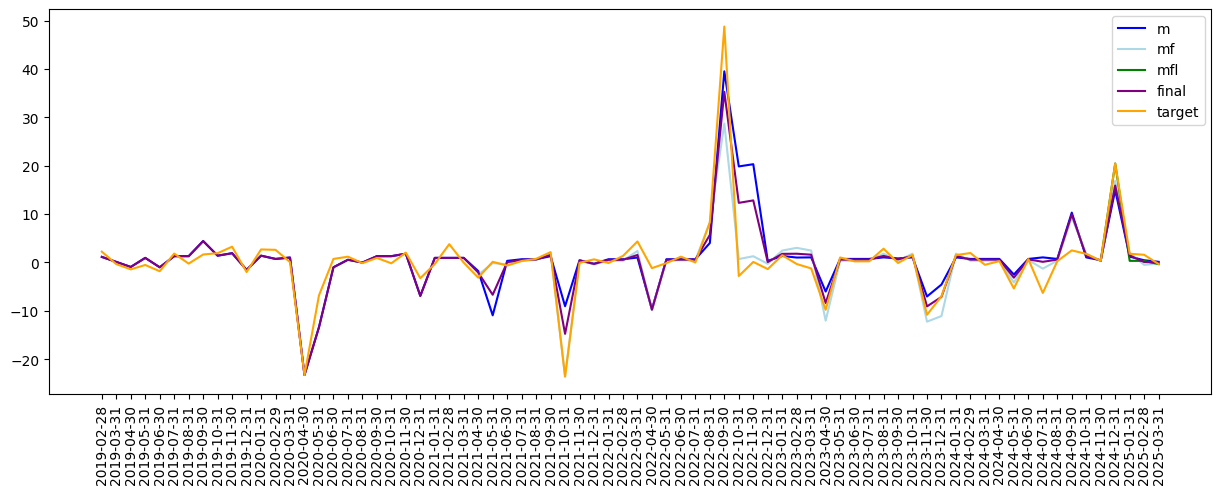

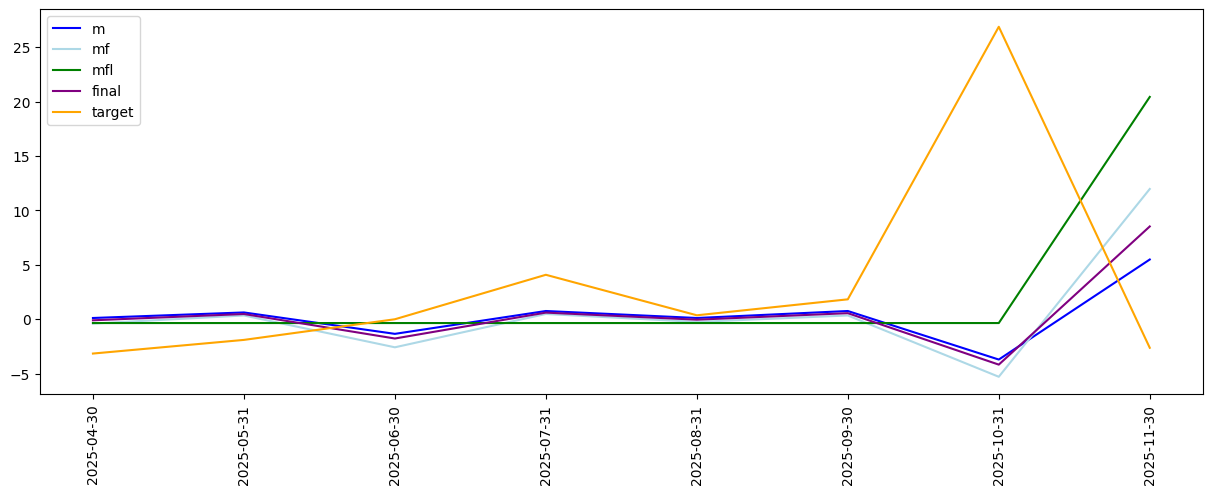

In [73]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5)
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results

### ANN

In [82]:
features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

Epoch 1/10


c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3727 - mae: 3.3727 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3576 - mae: 3.3576 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.3572 - mae: 3.3572 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3571 - mae: 3.3571 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3567 - mae: 3.3567 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3561 - mae: 3.3561 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.3557 - mae: 3.3557 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.3551 - mae: 3.3551 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.3546 - mae: 3.3546 - val_loss: 5

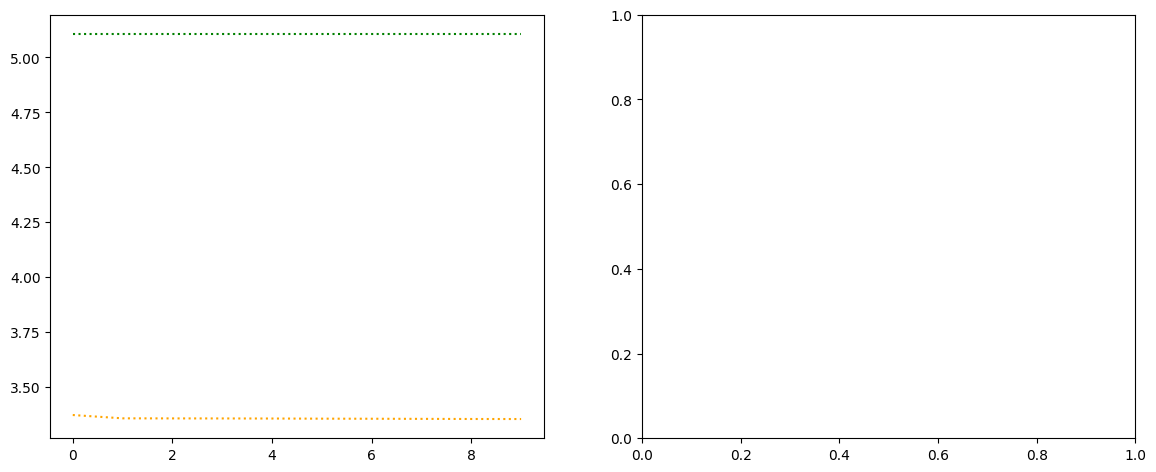

In [99]:
model_an = Sequential()
model_an.add(Dense(1,  input_dim=features_train_transf.shape[1]))#activation='sigmoid',
model_an.add(Dense(10, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
#model_an.add(Dense(15, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(10, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(1))#,activation = none))

model_an.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.SGD(),
                metrics = ["mae"])  # compile the model

#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 2)
hist = model_an.fit(features_train_transf, 
                    target_train, 
                    validation_data=(features_test_transf, target_test),
                    epochs=10, 
                    batch_size=32,
                    #callbacks=[early_stop]
                   )#fits the model
# batch_size: 32 bis 512, also 32, 64, 128, 256, 512


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5.5))
l = len(hist.history['loss'])
ax[0].plot(range(l), hist.history['loss'],linestyle=':', color = 'orange')
ax[0].plot(range(l), hist.history['val_loss'],linestyle=':', color = 'green')

In [104]:
features_train_transf.iloc[[0,1],:]

,Ferrero,LindtSpruengli,Mondelez,EinfPr_Süßwaren (ohne Dauerbackwaren)_lag_by_1,VPI_Schokoladen_lag_by_1,PCOCOUSDM_lag_by_1,PCOFFROBUSDM_lag_by_1,Geleistete Arbeitsstunden_WZ08-1082,Bruttolohn- und -gehaltssumme_WZ08-1082,"ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg"
date,,,,,,,,,,
2019-02-28,NaN,NaN,-1.877512,-0.557064,-0.900532,-0.577297,-0.89877,-0.180332,-1.022140,-0.885974
2019-03-31,NaN,NaN,-1.756921,-0.557064,-0.900532,-0.577297,-0.89877,-0.407618,-1.017112,-0.900447


In [105]:
model_an.predict(features_train_transf.iloc[[0,1],:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.029875],
       [0.029875]], dtype=float32)